In [1]:
import qiskit
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit
import qiskit_aer 
from qiskit.quantum_info import state_fidelity
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info.states.random import random_statevector
from qiskit.circuit.library import Initialize
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit_aer.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Operator

In [2]:
from itertools import combinations, cycle
coeff_dict  = {}

def array_k1(num_qubits):  #assuming num_qubits is even
    array_k = []
    m = num_qubits/2
    if (m)%2!=0: #replace with m-1 for previous results
        for j in range(-int((m)//2),int((m)//2) + 1): #replace with m-1 for previous results
            array_k.append(2*np.pi*j/num_qubits)
    else:
        for j in range(-int((m)//2),int((m)//2)):
            array_k.append(2*np.pi*j/num_qubits)
    return array_k


def recursive_nested(l,num_qubits,coeff_array,coeff = 1,bitstr=''):

    m = int(num_qubits/2) # taking always even number of qubits

    #coeff_dict_2 = {}
    if l==m-1: # m-1, but we start with 0 indexing
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                coeff = coeff*coeff_array[l,i]
                bitstr = bitstr + f'{i}'
                bitstr_sorted = sort_bitstr(bitstr) #to sort the string first
                perm = perm_str2(bitstr,bitstr_sorted) # to compare hamming distance
                if bitstr_sorted in coeff_dict.keys():
                    coeff_dict[bitstr_sorted]+=coeff*perm
                else:
                    coeff_dict[bitstr_sorted] = coeff*perm
            bitstr = bitstr_copy
            coeff = coeff_copy
    if l!=m-1:
        coeff_copy = coeff  #to ensure multiplied coeffs in previous rounds is preserved and reused
        bitstr_copy = bitstr
        for i in range(num_qubits):
            if str(i) in bitstr:
                pass
            else:
                #print(coeff)
                coeff = coeff*coeff_array[l,i]
                bitstr += str(i)
                recursive_nested(l+1,num_qubits,coeff_array,coeff,bitstr)
            bitstr = bitstr_copy
            coeff = coeff_copy

    return coeff_dict

def sort_bitstr(bitstr):
    bit_array = []
    for i in bitstr:
        bit_array.append(i)
    #print(bit_array)
    bitstr_sorted = ''
    for i in range(len(bit_array)):
        bit_array[i] = int(bit_array[i])
    bit_array.sort()
    #print(bit_array)
    for i in bit_array:
        #print(i,str(i))
        bitstr_sorted += str(i)
        #print(bitstr_sorted)

    return bitstr_sorted

def perm_str2(cmpr,word):

   #  word = 'eyssaasse' base string
   # cmpr = 'seasysaes'  a string to find number of swaps from the base string
    swaps = 0

    # 1)
    chars = {c: [] for c in word}
    [chars[c].append(i) for i, c in enumerate(word)]
    for k in chars.keys():
        chars[k] = cycle(chars[k])

    # 2)
    idxs = [next(chars[c]) for c in cmpr]

    # 3)
    for cmb in combinations(idxs, 2):
        if cmb[0] > cmb[1]:
            swaps += 1

    #print(swaps)
    if swaps%2 == 0:
        return 1
    else:
        return -1

In [3]:
#Let us first initialize the circuit and the state

def fermi_state(num_qubits): #of the form num_qubits = 2*odd number


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state
#Let us first initialize the circuit and the state

def fermi_state(num_qubits): #of the form num_qubits = 2*odd number


    coeff_dict.clear()
    m = int(num_qubits/2)
    coeff_array = []
    array_k = array_k1(num_qubits)
    for k in array_k:
        pos_list = []
        for x in range(num_qubits):
            pos_list.append(np.exp(-1j*k*x))
        coeff_array.append(pos_list)

    coeff_array = np.array(coeff_array)

    #print(coeff_array)

    coeff_dict_2 = recursive_nested(0,num_qubits,coeff_array)
    #print(coeff_dict_2)
    bitstr_dict = {}
    for bstr in coeff_dict_2.keys():
        vac_str = ''
        num_list = []
        for k in range(m):
            num_list.append(int(bstr[k]))

        for i in range(num_qubits):
            if i in num_list:
                vac_str += '1'
            else:
                vac_str += '0'
        bitstr_dict[vac_str] = coeff_dict[bstr]

    #print(bitstr_dict)
    

    fermi_state = Statevector([0]*(2**num_qubits))

    for bstr in bitstr_dict.keys():
        fermi_state += Statevector.from_label(bstr)*bitstr_dict[bstr]

    val_array = []
    for i in bitstr_dict.values():
        val_array.append(i)
    np_array = np.array(val_array)
    #print(np_array)
    #print(np.linalg.norm(np_array))
    
    fermi_state = fermi_state/np.linalg.norm(val_array)
    #print(fermi_state)
    fermi_state.is_valid()

    return fermi_state


In [4]:
N = 6 #number of sites (easier to apply fermi state to such site)
num_qubits = 2*N + 1

def fermi_state_circuit(N,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(N)
    fermi_state_down = fermi_state(N)
    qc.initialize(fermi_state_up,range(N))
    qc.initialize(fermi_state_down,range(N+1,2*N+1))
    return qc

def fermi_state_circuit2(num_qubits,num_cl_bits = 0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    fermi_state_up = fermi_state(int(num_qubits))
    qc.initialize(fermi_state_up,range(int(num_qubits)))
    return qc


def fermion_state(N,pos_list,num_cl_bits = 0):
    qc = QuantumCircuit(2*N+1,num_cl_bits)
    for i in range(2*N+1):
        if i in pos_list or i==N:
            continue
        else:
            qc.x(i)
    return qc





In [5]:
import math as m
import cmath as cm

def fsim(theta,phi,beta):
    fsim = Operator([[1,0,0,0],
                   [0,m.cos(theta),1j*cm.exp(1j*beta)*m.sin(theta),0],
                   [0,1j*cm.exp(-1j*beta)*m.sin(theta),m.cos(theta),0],
                   [0,0,0,cm.exp(1j*phi)]])
    return fsim

def add_fsim_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)
    fsim2 = fsim(2*theta,0,0)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits//2-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    for i in range(qc.num_qubits//2+2,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

def add_fsim_inv_half(qc,angles):
    theta = angles


    fsim1 = fsim(theta,0,0)

        
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits//2-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

    for i in range(qc.num_qubits//2+1,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

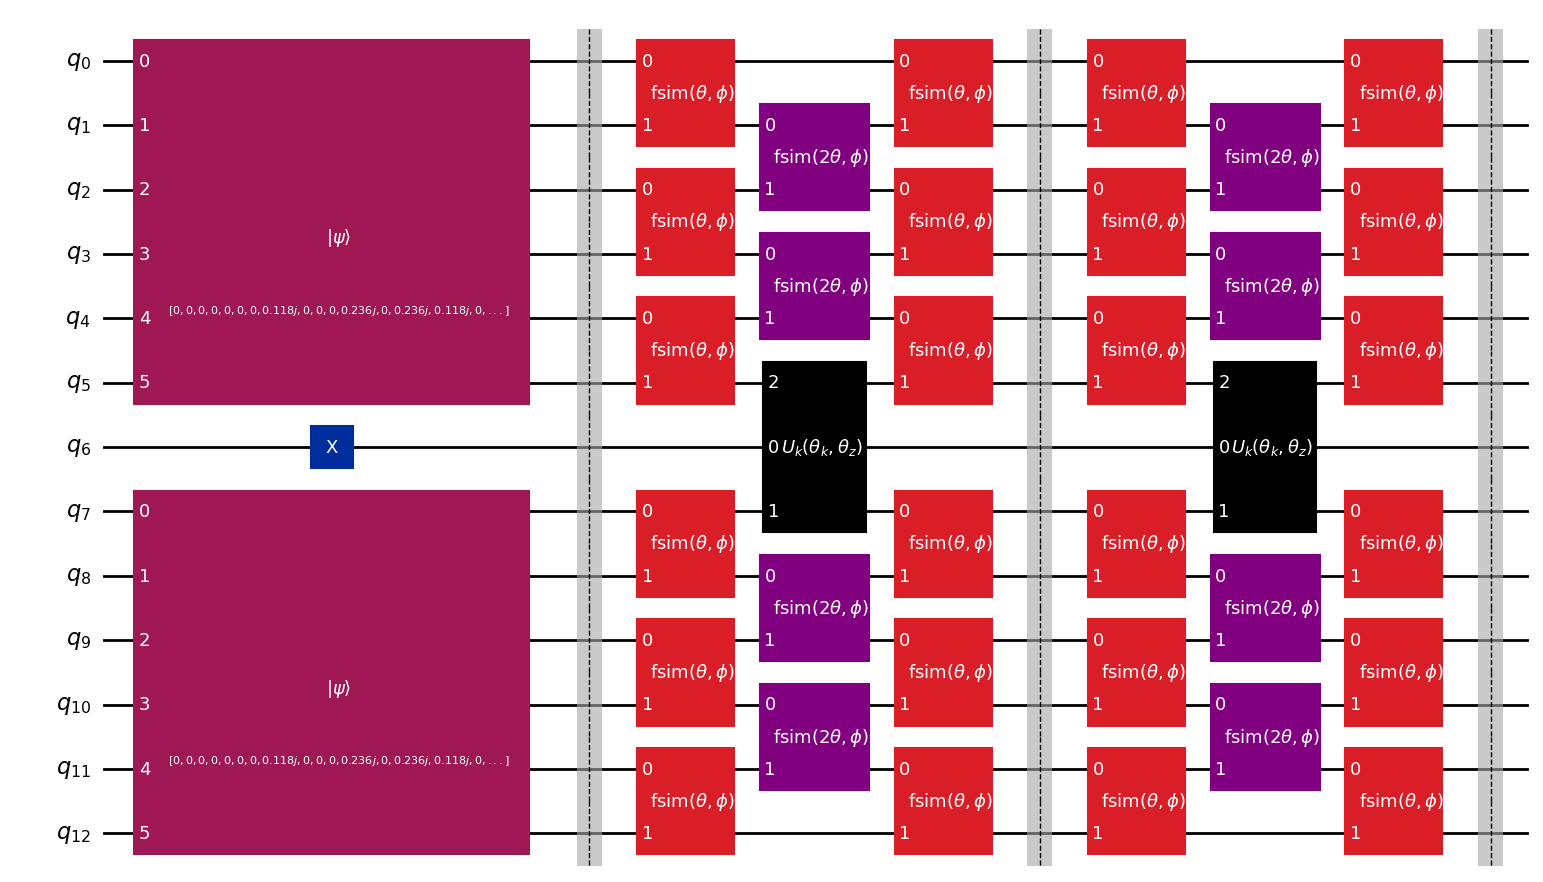

In [6]:
test_trotter_steps = 2
angles = np.pi/4


#Now we add the entire kondo circuit. This is the more efficient layered version as seen in our discussion

# Let us use the direct 8 by 8 unitary now for the problem

def kondo_unitary(theta_k,theta_z):

    l1 = cm.exp(1j*theta_z/2)
    l2 = cm.exp(-1j*theta_z/2)
    c1 = m.cos(theta_k)
    s1 = m.sin(theta_k)

    a = m.cos(np.sqrt(2)*theta_k) - (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    a_dag = m.cos(np.sqrt(2)*theta_k) + (1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    b = (-1j/np.sqrt(2))*m.sin(np.sqrt(2)*theta_k)
    c = cm.exp(-1j*theta_k) 
    d = cm.exp(1j*theta_k)

    """kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,l1,0,0,0,0,0],
                          [0,0,0,c1*l2,1j*l2*s1,0,0,0],
                          [0,0,0,1j*l2*s1,c1*l2,0,0,0],
                          [0,0,0,0,0,l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])"""
    kondo_unitary = Operator([[1,0,0,0,0,0,0,0],
                          [0,a,0,0,0,0,b,0],
                          [0,0,1,0,0,0,0,0],
                          [0,0,0,d,0,0,0,0],
                          [0,0,0,0,c,0,0,0],
                          [0,0,0,0,0,1,0,0],
                          [0,b,0,0,0,0,a_dag,0],
                          [0,0,0,0,0,0,0,1]])
    
    kondo_unitary_2 = Operator([[1,0,0,0,0,0,0,0],
                          [0,1,0,0,0,0,0,0],
                          [0,0,c1*l1,0,0,1j*s1*l1,0,0],
                          [0,0,0,l2,0,0,0,0],
                          [0,0,0,0,l2,0,0,0],
                          [0,0,1j*s1*l1,0,0,c1*l1,0,0],
                          [0,0,0,0,0,0,1,0],
                          [0,0,0,0,0,0,0,1]])
    
    return kondo_unitary_2

def circuit_3(N, pos_list, trotter_steps,angles = 0,theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = fermi_state_circuit(N)
    else:
        qc = fermi_state_circuit(N,num_cl_bits)
    qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    for i in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    if save == True:
        qc.save_statevector()
    #qc.save_statevector()  remove save for changing to operator
    return qc

qc = circuit_3(N,[2*N],test_trotter_steps,angles,trotter_barriers = True)


gate_colours = {
    "displaycolor": {
        r'fsim$(2\theta,\phi)$': [ # gate name
            "#800080", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'fsim$(\theta,\phi)$': [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'$U_{k}(\theta_k,\theta_z)$': [ # gate name
            "#000000", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
    },
}
qc.draw(output = 'mpl',style = gate_colours)

In [7]:
#Let us define two qc_lists, with 20 and 50 steps, which will be used later on in different parameter measurements

super_qc_list_20 = []
super_qc_list_50 = []

max_20 = 200
max_50 = 20
measured_bits =list(range(2*N + 1))
theta_list = [np.pi/2]
theta_k_list = [np.pi/3,np.pi/4,np.pi/6,np.pi/7, np.pi/8]


for theta in theta_list:
    for theta_k in theta_k_list:
        if theta_k > theta:
            continue
        else:
            theta_z = -theta_k
            qc_list = []
            qc_list_2 = []
            """for t in range(max_20):
                qc = circuit_3(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
                qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list.append(qc)
            super_qc_list_20.append((qc_list,theta,theta_k))"""

            for t in range(max_50):
                qc = circuit_3(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
                qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list_2.append(qc)
            super_qc_list_50.append((qc_list_2,theta,theta_k))


Theta is: 1.5707963267948966
Theta_k is: 0.5235987755982988


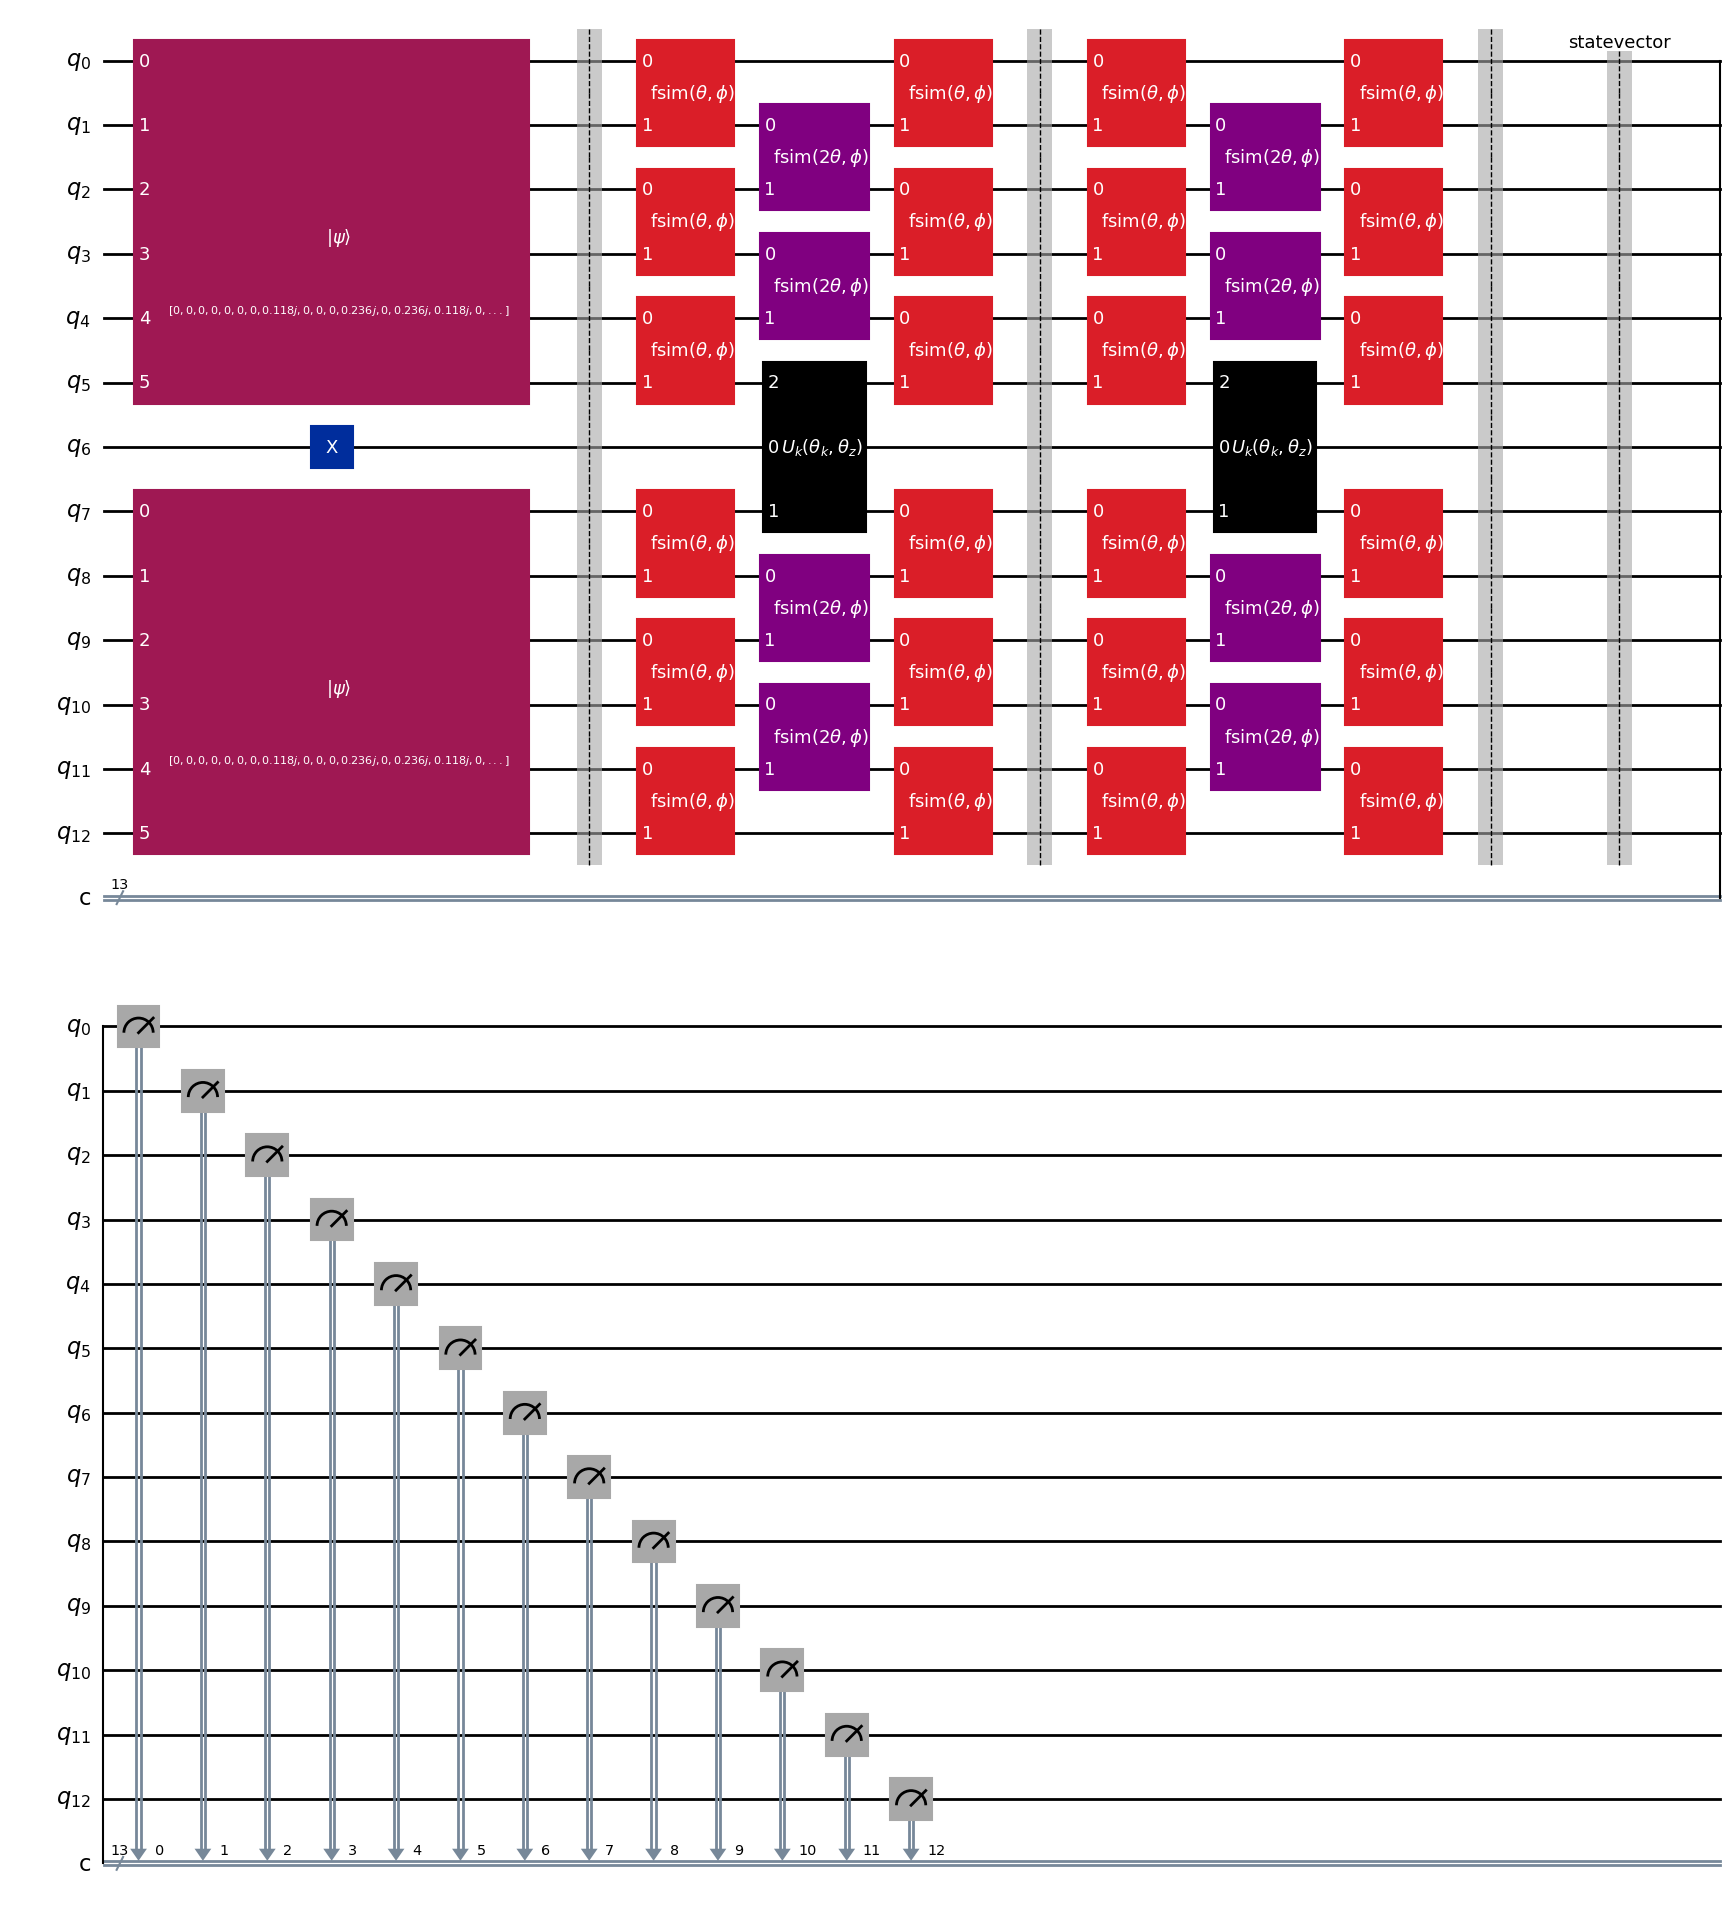

In [8]:
## The structure is: The first index is a indexing combination of parameters, the second gets a qc_list of 20 or 50 steps, and the third index is the actual qc at time step

qc = super_qc_list_50[2][0][2]
print("Theta is:",super_qc_list_50[2][1])
print("Theta_k is:",super_qc_list_50[2][2])

qc.draw(output = 'mpl',style = gate_colours)

In [9]:
## Let us also create a reference theta_super list

theta_super_list = []
for theta in theta_list:
    for theta_k in theta_k_list:
        if theta_k > theta:
            continue
        else:
            theta_super_list.append((theta,theta_k))

print(theta_super_list)

[(1.5707963267948966, 1.0471975511965976), (1.5707963267948966, 0.7853981633974483), (1.5707963267948966, 0.5235987755982988), (1.5707963267948966, 0.4487989505128276), (1.5707963267948966, 0.39269908169872414)]


In [10]:
estimator = Estimator(approximation=True)
sampler = Sampler()

In [13]:
## Now that we have our circuits with different parameters, we can measure the <H_total> and <S^z_imp> for each of these circuits



def plot_mag_impurity_20(super_qc_list_20):
    for i in range(len(super_qc_list_20)):
        theta = super_qc_list_20[i][1]
        theta_k = super_qc_list_20[i][2]
        qc_list = super_qc_list_20[i][0]
        imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*200
        job_1 = estimator.run(qc_list,imp_observables,shots = None)
        expectation_list_1 = list(job_1.result().values)
        for i in range(200):
            if expectation_list_1[i]  == expectation_list_1[0]:
                print ("Rec time is:",i)
            
            
        plt.plot(range(200),expectation_list_1,label = 'Impurity, {0},{1}'.format(theta,theta_k))
        plt.title(f'Impurity Magnetization for Theta = {round(theta,2)} and Theta_k = {round(theta_k,2)}')
        plt.xlabel('Time (Trotter Steps)')
        plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
        plt.show()

def plot_mag_impurity_50(super_qc_list_50):
    for i in range(len(super_qc_list_50)):
        theta = super_qc_list_50[i][1]
        theta_k = super_qc_list_50[i][2]
        qc_list = super_qc_list_50[i][0]
        imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*20
        job_1 = estimator.run(qc_list,imp_observables,shots = None)
        expectation_list_1 = list(job_1.result().values)
        """c = 0
        for i in range(1,500):
            if abs(expectation_list_1[i]  - expectation_list_1[0]) <= 1e-4:
                c = 1
                print (f"Rec time  for theta = {theta} and theta_k = {theta_k} is:",i)
        if c == 0:
            print(f"Rec time  for theta = {theta} and theta_k = {theta_k} is not found")"""
        print(expectation_list_1)
        plt.plot(range(20),expectation_list_1,label = 'Impurity, {0},{1}'.format(theta,theta_k))
        plt.title(f'Impurity Magnetization for Theta = {round(theta,2)} and Theta_k = {round(theta_k,2)}')
        plt.xlabel('Time (Trotter Steps)')
        plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
        plt.show()

    
    

In [17]:
plot_mag_impurity_20(super_qc_list_20)

[-0.9999999999999999, -0.6250000000000001, -0.6250000000000001, -0.9999999999999999, -0.6250000000000001, -0.6250000000000001, -0.9999999999999999, -0.6250000000000001, -0.625, -0.9999999999999999, -0.6250000000000004, -0.6249999999999999, -0.9999999999999999, -0.6250000000000014, -0.6249999999999999, -0.9999999999999999, -0.6250000000000014, -0.6249999999999999, -0.9999999999999999, -0.6250000000000014]


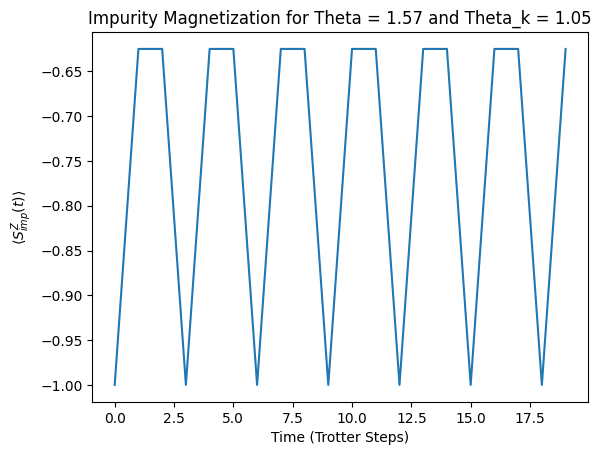

[-0.9999999999999999, -0.75, -0.5000000000000001, -0.75, -0.9999999999999999, -0.7500000000000001, -0.5000000000000001, -0.75, -0.9999999999999999, -0.7500000000000001, -0.49999999999999994, -0.7500000000000001, -0.9999999999999999, -0.7500000000000001, -0.49999999999999994, -0.75, -0.9999999999999999, -0.75, -0.49999999999999994, -0.7500000000000001]


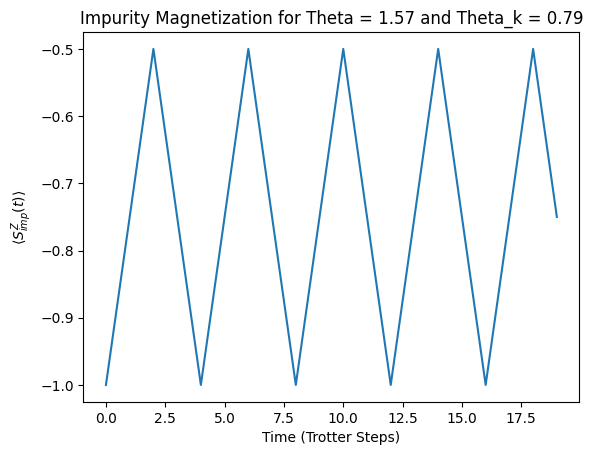

[-0.9999999999999999, -0.8749999999999999, -0.6250000000000001, -0.5000000000000001, -0.6250000000000001, -0.8749999999999999, -0.9999999999999999, -0.8749999999999999, -0.6250000000000001, -0.5000000000000001, -0.6250000000000001, -0.8749999999999999, -0.9999999999999999, -0.8749999999999999, -0.6250000000000001, -0.5000000000000001, -0.6250000000000001, -0.8749999999999988, -0.9999999999999999, -0.8749999999999999]


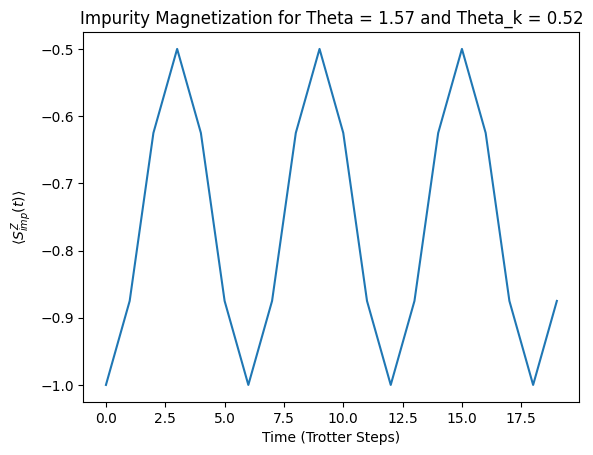

[-0.9999999999999999, -0.905872450464683, -0.6943697665109235, -0.5247577830243959, -0.5247577830243959, -0.6943697665109227, -0.905872450464683, -0.9999999999999999, -0.905872450464683, -0.6943697665109235, -0.524757783024396, -0.524757783024396, -0.6943697665109222, -0.9058724504646802, -0.9999999999999999, -0.905872450464683, -0.6943697665109235, -0.524757783024396, -0.524757783024396, -0.694369766510922]


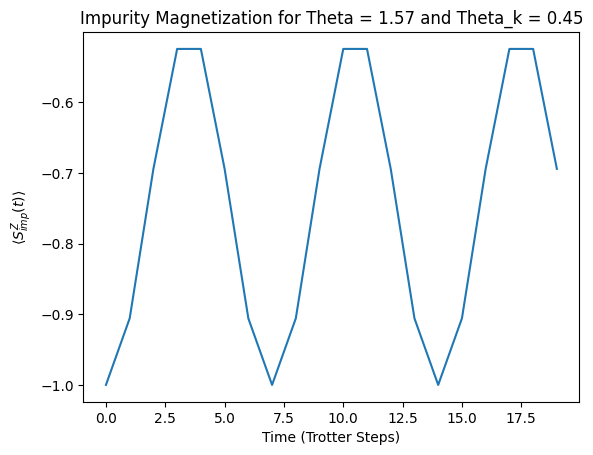

[-0.9999999999999999, -0.9267766952966379, -0.75, -0.5732233047033619, -0.5000000000000001, -0.5732233047033619, -0.7499999999999999, -0.9267766952966379, -0.9999999999999999, -0.9267766952966379, -0.75, -0.5732233047033619, -0.5000000000000001, -0.5732233047033622, -0.75, -0.9267766952966379, -0.9999999999999999, -0.9267766952966373, -0.7499999999999999, -0.5732233047033621]


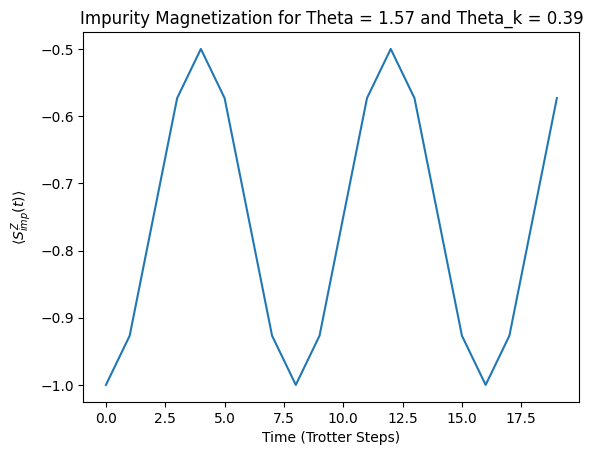

In [14]:
plot_mag_impurity_50(super_qc_list_50)  #Will take around 45 mins to run

## Code for <H(t)> 

In [15]:
H_t = 0
H_k = 0
for i in range(2*N):
    if i==N-1 or i==N:
        continue
    else:
        H_t += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(2*N-i-1)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(2*N-i-1)))
H_k = (-theta_k/2)*(SparsePauliOp('I'*(N-1) + 'XXX' + 'I'*(N-1))+SparsePauliOp('I'*(N-1) + 'YXY' + 'I'*(N-1)) + SparsePauliOp('I'*(N-1) + 'XYY' + 'I'*(N-1))- SparsePauliOp('I'*(N-1) + 'YYX' + 'I'*(N-1))+ SparsePauliOp('I'*(N) + 'ZZ' + 'I'*(N-1)) - SparsePauliOp('I'*(N-1) + 'ZZ' + 'I'*(N)))

In [28]:
def plot_hexp_50(super_qc_list_50):
    for i in range(len(super_qc_list_50)):
        theta = super_qc_list_50[i][1]
        theta_k = super_qc_list_50[i][2]
        qc_list = super_qc_list_50[i][0]

        H_t = 0
        H_k = 0
        for i in range(2*N):
            if i==N-1 or i==N:
                continue
            else:
                H_t += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(2*N-i-1)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(2*N-i-1)))
        H_k = (-theta_k/2)*(SparsePauliOp('I'*(N-1) + 'XXX' + 'I'*(N-1))+SparsePauliOp('I'*(N-1) + 'YXY' + 'I'*(N-1)) + SparsePauliOp('I'*(N-1) + 'XYY' + 'I'*(N-1))- SparsePauliOp('I'*(N-1) + 'YYX' + 'I'*(N-1))+ SparsePauliOp('I'*(N) + 'ZZ' + 'I'*(N-1)) - SparsePauliOp('I'*(N-1) + 'ZZ' + 'I'*(N)))

                

        h_analytical = [H_t + H_k]*500
        #print("Operator obtained from circuit")
        job_analytical = estimator.run(qc_list,h_analytical,shots = None)
        h_values1 = list(job_analytical.result().values)
        c = 0
        for i in range(1,500):
            if abs(h_values1[i]  - h_values1[0]) <= 1e-3:
                c = 1
                print (f"Rec time  for theta = {theta} and theta_k = {theta_k} is:",i)
        if c == 0:
            print(f"Rec time  for theta = {theta} and theta_k = {theta_k} is not found")

        plt.plot(range(500),h_values1,label = 'Total Hamiltonian analytical')
        plt.xlabel('Time (trotter steps)')
        plt.ylabel(r'$\langle H(t) \rangle$')
        plt.title(f'Hamiltonian Expectation for Theta = {round(theta,2)} and Theta_k = {round(theta_k,2)}')
        plt.show()

Rec time  for theta = 1.0471975511965976 and theta_k = 0.7853981633974483 is: 446


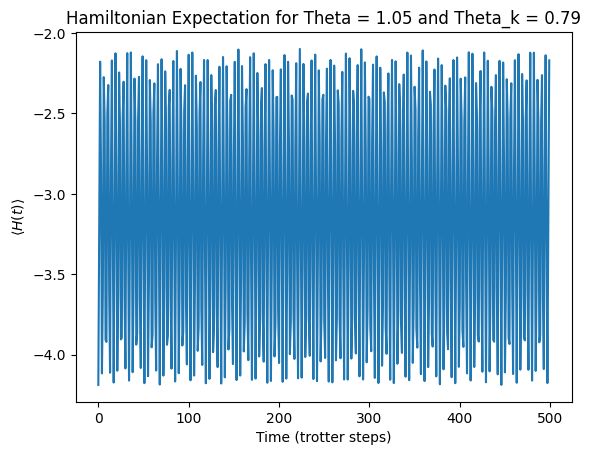

Rec time  for theta = 1.0471975511965976 and theta_k = 0.5235987755982988 is: 266


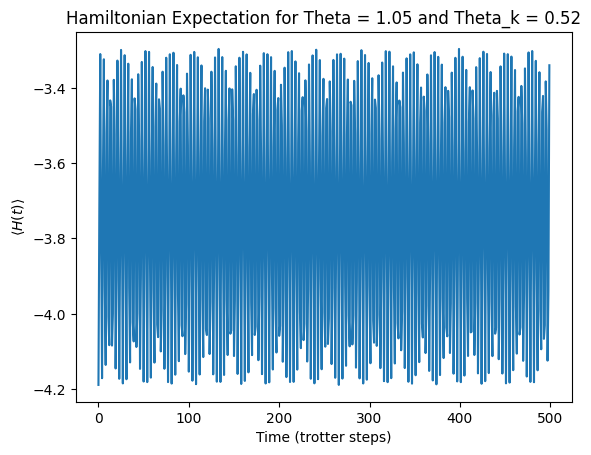

Rec time  for theta = 0.7853981633974483 and theta_k = 0.7853981633974483 is: 200


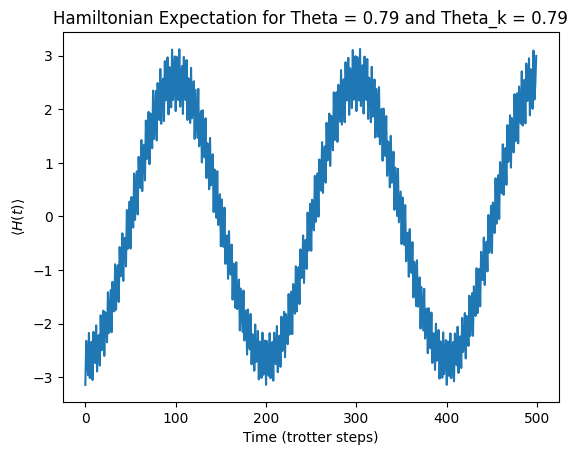

Rec time  for theta = 0.7853981633974483 and theta_k = 0.5235987755982988 is not found


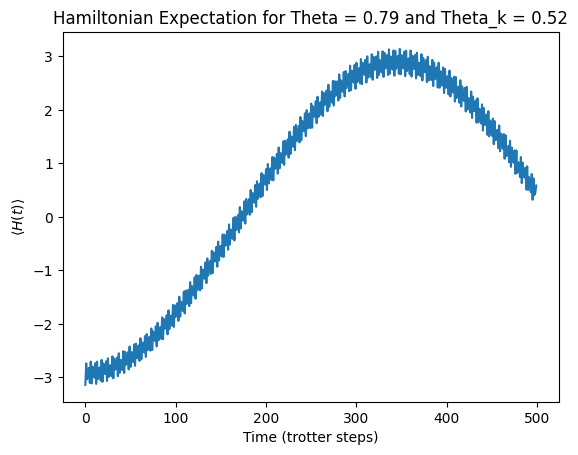

In [29]:
plot_hexp_50(super_qc_list_50)

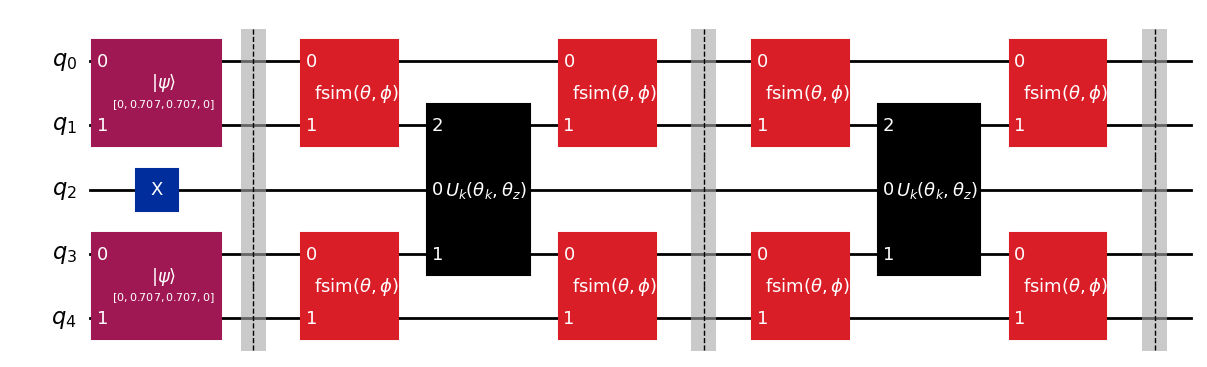

In [10]:
## Let us also define the translationally invariant state

def ts_state(N):
    str1 = ''
    str2 = ''
    for i in range(N):
        if i%2==0:
            str1 += '0'
            str2 += '1'
        else:
            str1 += '1'
            str2 += '0'
    state = (Statevector.from_label(str1) + Statevector.from_label(str2))/np.sqrt(2)
    return state

    

def ts_circuit(N,num_cl_bits=0):
    qc = QuantumCircuit(num_qubits,num_cl_bits)
    ts_state_up = ts_state(N)
    ts_state_down = ts_state(N)
    #print(ts_state_down)
    qc.initialize(ts_state_up,range(N))
    qc.initialize(ts_state_down,range(N+1,2*N+1))
    return qc


def circuit_ts(N,pos_list, trotter_steps,angles = 0,theta_k = 0,theta_z = 0, num_cl_bits = 0, trotter_barriers = False, save = False):
    if num_cl_bits == 0:
        qc = ts_circuit(N)
    else:
        qc = ts_circuit(N,num_cl_bits)
    qc.x(N)
    qc.barrier()
    
    c = num_qubits//2
    for i in range(trotter_steps):
        add_fsim_half(qc,angles)
        qc.unitary(kondo_unitary(theta_k,theta_z),[c,c+1,c-1],label=r'$U_{k}(\theta_k,\theta_z)$')
        add_fsim_inv_half(qc,angles)
        if trotter_barriers:
            qc.barrier()
    if save == True:
        qc.save_statevector()
    #qc.save_statevector()  remove save for changing to operator
    return qc

qc = circuit_ts(N,[2*N],test_trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl',style = gate_colours)

    

    


In [29]:
super_ts_list_20 = []
super_ts_list_50 = []

max_20 = 200
max_50 = 500
measured_bits =list(range(2*N + 1))
theta_list = [np.pi/3,np.pi/4]
theta_k_list = [np.pi/4,np.pi/6]


for theta in theta_list:
    for theta_k in theta_k_list:
        if theta_k > theta:
            continue
        else:
            theta_z = -theta_k
            qc_list = []
            qc_list_2 = []
            """for t in range(max_20):
                qc = circuit_ts(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
                qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list.append(qc)
            super_ts_list_20.append((qc_list,theta,theta_k))"""

            for t in range(max_50):
                qc = circuit_ts(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
                qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list_2.append(qc)
            super_ts_list_50.append((qc_list_2,theta,theta_k))

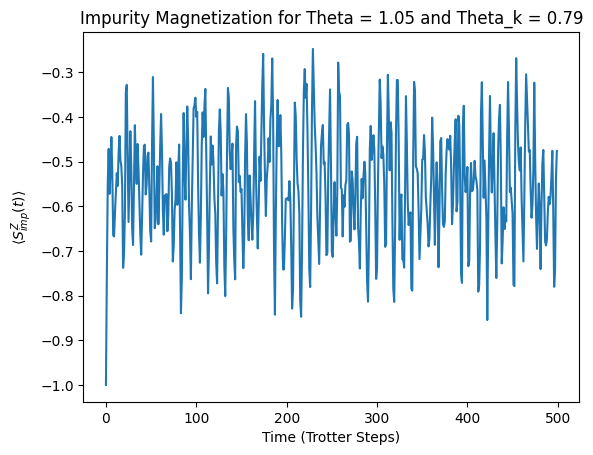

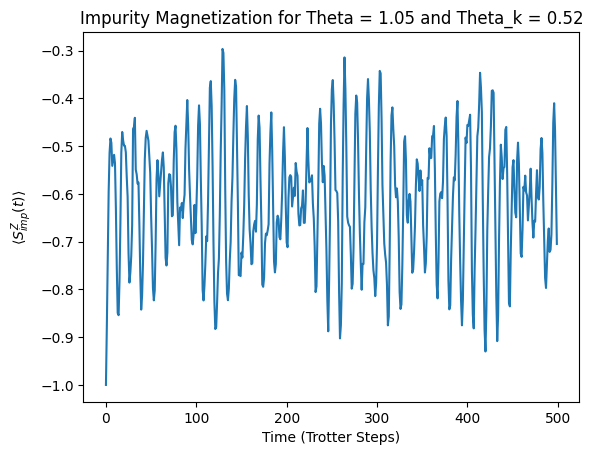

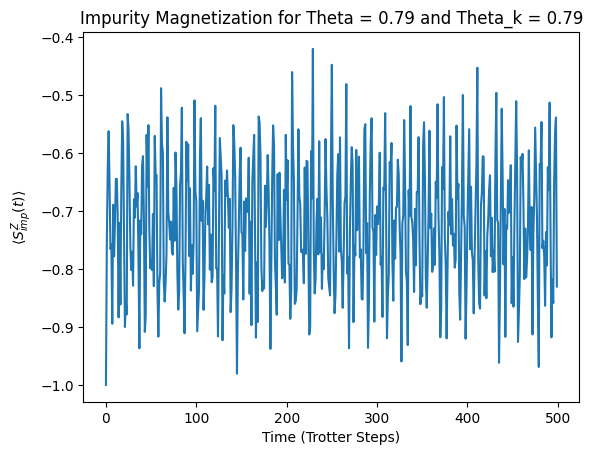

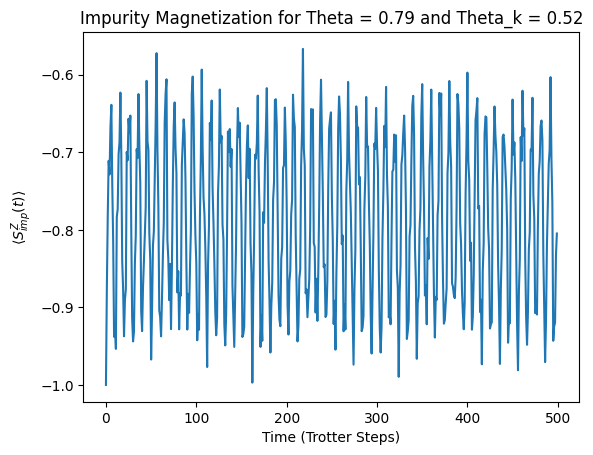

In [30]:
plot_mag_impurity_50(super_ts_list_50)

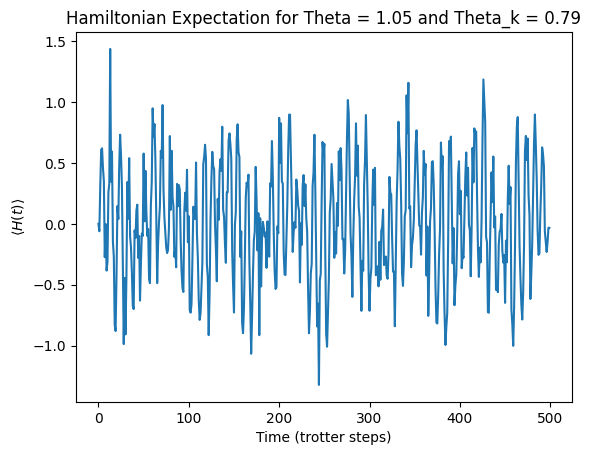

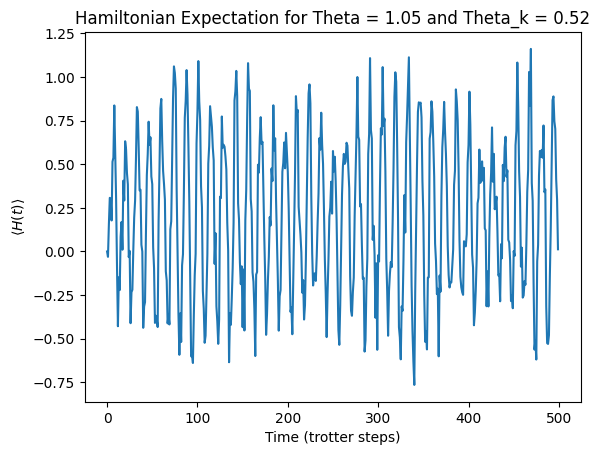

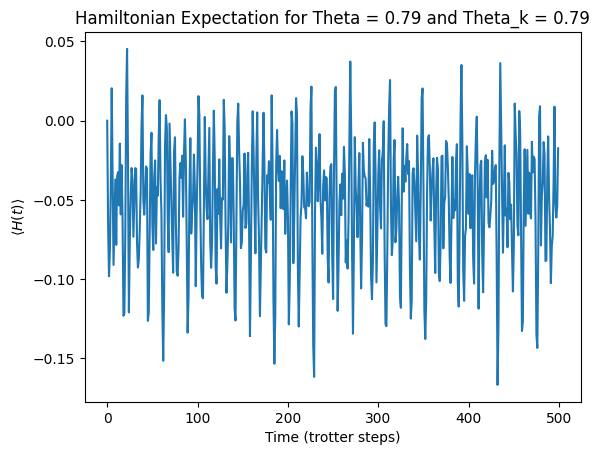

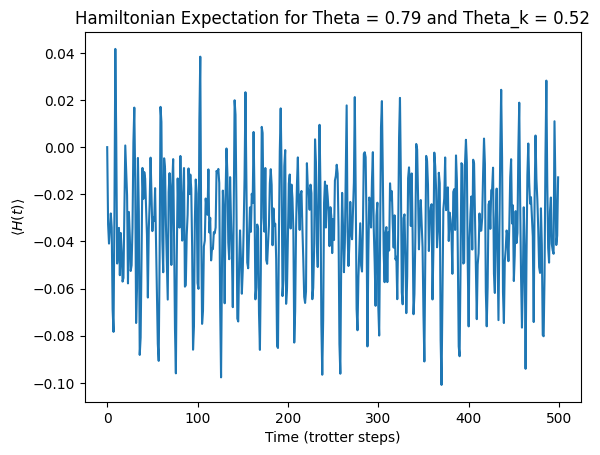

In [33]:
plot_hexp_50(super_ts_list_50)

In [20]:
def plot_compareTSFS(super_qc_list50, super_ts_list_50, theta,theta_k, color = 'r'):
    for i in range(len(theta_super_list)):
        if theta == theta_super_list[i][0] and theta_k == theta_super_list[i][1]:
            qc_list1 = super_qc_list50[i][0]
            qc_list2 = super_ts_list_50[i][0]
            imp_observables = [SparsePauliOp('I'*N + 'Z' + 'I'*N)]*50
            job_1 = estimator.run(qc_list1,imp_observables,shots = None)
            job_2 = estimator.run(qc_list2,imp_observables,shots = None)
            expectation_list_1 = list(job_1.result().values)
            expectation_list_2 = list(job_2.result().values)
            plt.plot(range(50),expectation_list_1,color + "-",label = r'FS State, $\theta =$' +  f"{round(theta,2)}" + r' $\theta_k =$' + f"{round(theta_k,2)}")
            plt.plot(range(50),expectation_list_2,color + "--",label = r'TS State, $\theta =$' +  f"{round(theta,2)}" + r' $\theta_k =$' + f"{round(theta_k,2)}")
            

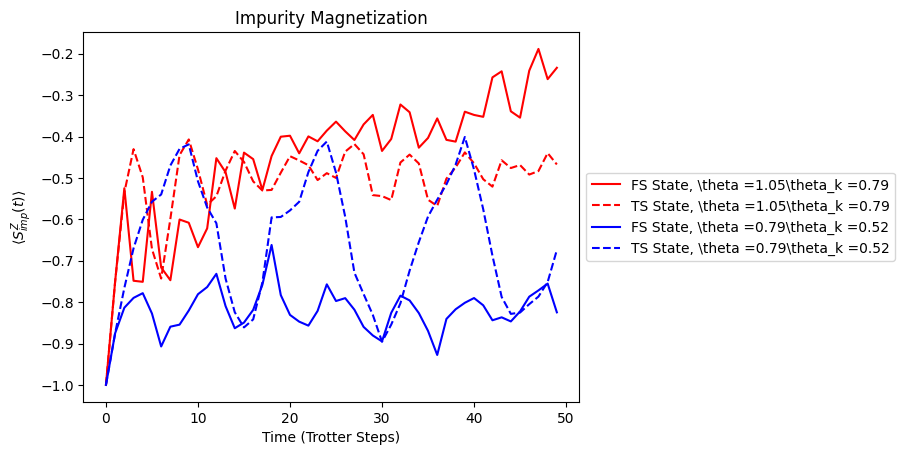

In [21]:
plot_compareTSFS(super_qc_list_50,super_ts_list_50,np.pi/3,np.pi/4,'r')
plot_compareTSFS(super_qc_list_50,super_ts_list_50,np.pi/4,np.pi/6,'b')

plt.title(f'Impurity Magnetization')
plt.xlabel('Time (Trotter Steps)')
plt.ylabel(r'$\langle S^Z_{imp}(t) \rangle$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [24]:
def plot_compareTSFS_h(super_qc_list50, super_ts_list_50, theta,theta_k, color = 'r'):
    for i in range(len(theta_super_list)):
        if theta == theta_super_list[i][0] and theta_k == theta_super_list[i][1]:
            qc_list1 = super_qc_list50[i][0]
            qc_list2 = super_ts_list_50[i][0]

            h_analytical = [H_t + H_k]*50
        #print("Operator obtained from circuit")
            
            job_1 = estimator.run(qc_list1,h_analytical,shots = None)
            job_2 = estimator.run(qc_list2,h_analytical,shots = None)
            expectation_list_1 = list(job_1.result().values)
            expectation_list_2 = list(job_2.result().values)
            plt.plot(range(50),expectation_list_1,color + "-",label = r'FS State, $\theta =$' +  f"{round(theta,2)}" + r' $\theta_k =$' + f"{round(theta_k,2)}")
            plt.plot(range(50),expectation_list_2,color + "--",label = r'TS State, $\theta =$' +  f"{round(theta,2)}" + r' $\theta_k =$' + f"{round(theta_k,2)}")

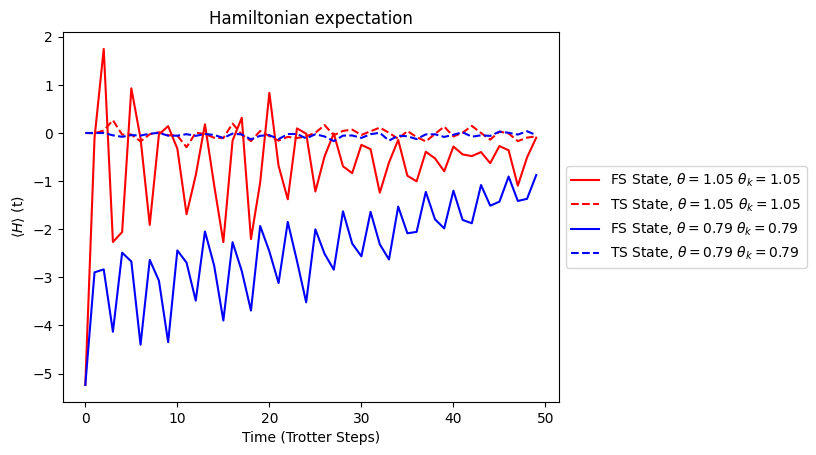

In [25]:
plot_compareTSFS_h(super_qc_list_50,super_ts_list_50,np.pi/3,np.pi/3,'r')
plot_compareTSFS_h(super_qc_list_50,super_ts_list_50,np.pi/4,np.pi/4,'b')

plt.title(f'Hamiltonian expectation')
plt.xlabel('Time (Trotter Steps)')
plt.ylabel(r'$\langle H \rangle$ (t)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

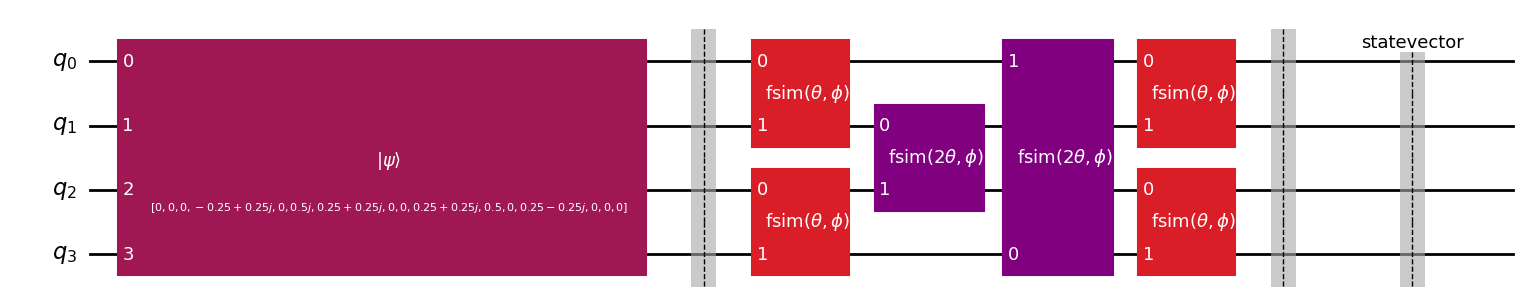

In [29]:
## Now we will run only the TS state on the periodic free fermion circuit and analyse the results for recurrence of <h_t>
N = 4
# Let us try a more symmetrised version with a ring circuit
fermi_state1 = fermi_state(N)
ts_state1 = ts_state(N)

num_qubits = N #for this circuit

angles  = [np.pi/4,0,0]

def circuit_sym(num_qubits, trotter_steps,angles = [0,0,0], num_cl_bits = 0, trotter_barriers = False):
    if num_cl_bits == 0:
        qc = QuantumCircuit(num_qubits)
    else:
        qc = QuantumCircuit(num_qubits, num_cl_bits)
    qc.initialize(fermi_state1)
    qc.barrier()
    for trotter_step in range(trotter_steps):
        add_fsim_sym(qc,angles)
        if trotter_barriers:
            qc.barrier()

    qc.save_statevector()  #this is to check the statevector after a fixed number of trotter steps
    return qc

def add_fsim_sym(qc,angles):
    theta = angles[0]
    phi = angles[1]
    beta = angles[2]

    fsim1 = fsim(theta/2,phi,beta)
    fsim2 = fsim(theta,phi,beta)
    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')
        
    #Adding fsim in odd layers
    for i in range(1,qc.num_qubits-1,2):
        qc.unitary(fsim2,[i,i+1],label = r'fsim$(2\theta,\phi)$')

    qc.unitary(fsim2,[qc.num_qubits-1,0],label = r'fsim$(2\theta,\phi)$')

    #Adding fsim in even layers
    for i in range(0,qc.num_qubits-1,2):
        qc.unitary(fsim1,[i,i+1],label = r'fsim$(\theta,\phi)$')

trotter_steps = 1

gate_colours = {
    "displaycolor": {
        r'fsim$(2\theta,\phi)$': [ # gate name
            "#800080", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'fsim$(\theta,\phi)$': [ # gate name
            "#da1e28", # box color (red)
            "#FFFFFF" # box text color (white)
        ],

        r'$U_{k}(\theta_k,\theta_z)$': [ # gate name
            "#000000", # box color (red)
            "#FFFFFF" # box text color (white)
        ],
    },
}


qc = circuit_sym(num_qubits,trotter_steps,angles,trotter_barriers = True)
qc.draw(output = 'mpl', style=gate_colours)

In [30]:
Ht_new = 0
for i in range(N-1):
        Ht_new += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(N-i-2)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(N-i-2)))

super_ff_list = []

for theta in theta_list:
        angles = [theta,0,0]
        qc_list_3 = []
        """for t in range(max_20):
                qc = circuit_ts(N,[0,1,2*N], t, theta,theta_k,theta_z,num_cl_bits = len(measured_bits), trotter_barriers = True, save = True)
                qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list.append(qc)
            super_ts_list_20.append((qc_list,theta,theta_k))"""
        for t in range(max_50):
                qc = circuit_sym(N, t, angles,num_cl_bits = 0, trotter_barriers = True)
                #qc.measure(measured_bits,list(range(len(measured_bits))))
                qc_list_3.append(qc)
        super_ff_list.append((qc_list_3,theta))


In [31]:
def plot_hexp_ff(super_ff_list):
    for i in range(len(super_ff_list)):
        theta = super_ff_list[i][1]
        #theta_k = super_qc_list_50[i][2]
        qc_list = super_ff_list[i][0]

        Ht_new = 0
        #for i in range(N-1):
         #       Ht_new += -theta*(SparsePauliOp('I'*(i) + 'XX' + 'I'*(N-i-2)) + SparsePauliOp('I'*(i) + 'YY' + 'I'*(N-i-2)))
        j = 0  #take value between 0 to N - 1
        Ht_new = 0.5*(SparsePauliOp('I'*(j) + 'I' + 'I'*(N-j-1)) + SparsePauliOp('I'*(j) + 'Z' + 'I'*(N-j-1)))
        print("Ht_new:", Ht_new)
        h_analytical = [Ht_new]*500

        job_1 = estimator.run(qc_list,h_analytical,shots = None)
        expectation_list_1 = list(job_1.result().values)
        c = 0
        for i in range(1,500):
            if abs(expectation_list_1[i]  - expectation_list_1[0]) <= 1e-3:
                c = 1
                print (f"Rec time  for theta = {theta} is:",i)
        if c == 0:
            print(f"Rec time  for theta = {theta} is not found")
        
        plt.plot(range(500),expectation_list_1,label = 'Total Hamiltonian analytical')
        plt.xlabel('Time (trotter steps)')
        plt.ylabel(f'Occupation number of site {j}')
        plt.title(f'FF Hamiltonian Expectation for Theta = {round(theta,2)}')
        plt.show()


    


Ht_new: SparsePauliOp(['IIII', 'ZIII'],
              coeffs=[0.5+0.j, 0.5+0.j])
Rec time  for theta = 1.0471975511965976 is not found


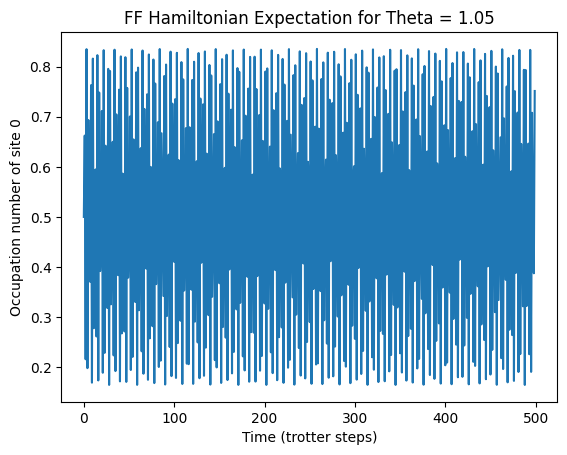

Ht_new: SparsePauliOp(['IIII', 'ZIII'],
              coeffs=[0.5+0.j, 0.5+0.j])
Rec time  for theta = 0.7853981633974483 is: 3
Rec time  for theta = 0.7853981633974483 is: 6
Rec time  for theta = 0.7853981633974483 is: 9
Rec time  for theta = 0.7853981633974483 is: 12
Rec time  for theta = 0.7853981633974483 is: 15
Rec time  for theta = 0.7853981633974483 is: 18
Rec time  for theta = 0.7853981633974483 is: 21
Rec time  for theta = 0.7853981633974483 is: 24
Rec time  for theta = 0.7853981633974483 is: 27
Rec time  for theta = 0.7853981633974483 is: 30
Rec time  for theta = 0.7853981633974483 is: 33
Rec time  for theta = 0.7853981633974483 is: 36
Rec time  for theta = 0.7853981633974483 is: 39
Rec time  for theta = 0.7853981633974483 is: 42
Rec time  for theta = 0.7853981633974483 is: 45
Rec time  for theta = 0.7853981633974483 is: 48
Rec time  for theta = 0.7853981633974483 is: 51
Rec time  for theta = 0.7853981633974483 is: 54
Rec time  for theta = 0.7853981633974483 is: 57
Rec time  

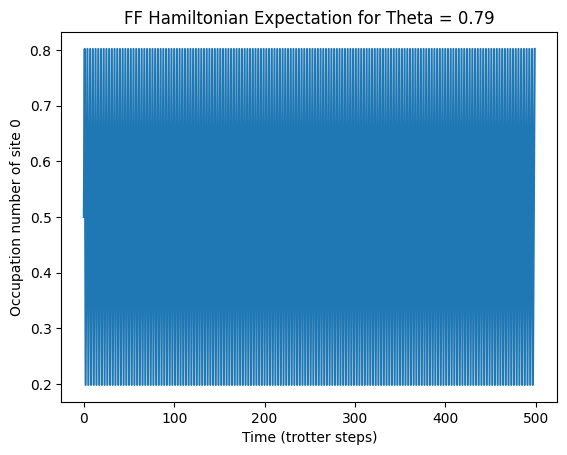

In [32]:
plot_hexp_ff(super_ff_list)